In [153]:
import os
import time
import math
import glob
import string
import random 

import torch
import torch.nn as nn

from rnn.helpers import time_since

%matplotlib inline

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Language recognition with an RNN

If you've ever used an online translator you've probably seen a feature that automatically detects the input language. While this might be easy to do if you input unicode characters that are unique to one or a small group of languages (like "你好" or "γεια σας"), this problem is more challenging if the input only uses the available ASCII characters. In this case, something like "těší mě" would beome "tesi me" in the ascii form. This is a more challenging problem in which the language must be recognized purely by the pattern of characters rather than unique unicode characters.

We will train an RNN to solve this problem for a small set of languages thta can be converted to romanized ASCII form. For training data it would be ideal to have a large and varied dataset in different language styles. However, it is easy to find copies of the Bible which is a large text translated to different languages but in the same easily parsable format, so we will use 20 different copies of the Bible as training data. Using the same book for all of the different languages will hopefully prevent minor overfitting that might arise if we used different books for each language (fitting to common characteristics of the individual books rather than the language).

In [155]:
from unidecode import unidecode as unicodeToAscii

all_characters = string.printable
n_letters = len(all_characters)

print(unicodeToAscii('těší mě'))

tesi me


In [156]:
# Read a file and split into lines
def readFile(filename):
    data = open(filename, encoding='utf-8').read().strip()
    return unicodeToAscii(data)

def get_category_data(data_path):
    # Build the category_data dictionary, a list of names per language
    category_data = {}
    all_categories = []
    for filename in glob.glob(data_path):
        category = os.path.splitext(os.path.basename(filename))[0].split('_')[0]
        all_categories.append(category)
        data = readFile(filename)
        category_data[category] = data
    
    return category_data, all_categories

The original text is split into two parts, train and test, so that we can make sure that the model is not simply memorizing the train data.

In [157]:
train_data_path = 'language_data/train/*_train.txt'
test_data_path = 'language_data/test/*_test.txt'

train_category_data, all_categories = get_category_data(train_data_path)
test_category_data, test_all_categories = get_category_data(test_data_path)

n_languages = len(all_categories)

print(len(all_categories))
print(all_categories)

20
['english', 'esperanto', 'albanian', 'finnish', 'spanish', 'italian', 'lithuanian', 'french', 'maori', 'romanian', 'german', 'portuguese', 'turkish', 'swedish', 'hungarian', 'czech', 'vietnamese', 'xhosa', 'danish', 'norwegian']


# Data processing

In [158]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1, dim=1)
    category_i = top_i[:, 0]
    return category_i

# Turn string into long tensor
def stringToTensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, 1).long().to(device)
    input_text = []
    for i in range(batch_size):
        category = all_categories[random.randint(0, len(all_categories) - 1)]
        line_start = random.randint(0, len(text[category])-chunk_len)
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line = text[category][line_start:line_start+chunk_len]
        input_text.append(line)
        input_data[i] = stringToTensor(line)
        target[i] = category_tensor
    return input_data, target, input_text

Implement Model
====================

For this classification task, we can use the same model we implement for the generation task which is located in `rnn/model.py`. See the `MP4_P2_generation.ipynb` notebook for more instructions. In this case each output vector of our RNN will have the dimension of the number of possible languages (i.e. `n_languages`). We will use this vector to predict a distribution over the languages.

In the generation task, we used the output of the RNN at every time step to predict the next letter and our loss included the output from each of these predictions. However, in this task we use the output of the RNN at the end of the sequence to predict the language, so our loss function will use only the predicted output from the last time step.



# Train RNN

In [159]:
from rnn.model import RNN

In [166]:
chunk_len = 50

BATCH_SIZE = 128
n_epochs = 5000
hidden_size = 120
n_layers = 2 ##1 2 3
learning_rate = 0.009
model_type = 'gru'

criterion = nn.CrossEntropyLoss()
rnn = RNN(n_letters, hidden_size, n_languages, model_type=model_type, n_layers=n_layers).to(device)

**TODO:** Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and the next hidden layer representation. The cross entropy loss should be computed over the last RNN output scores from the end of the sequence and the target classification tensor. Lastly, call backward on the loss and take an optimizer step.

In [167]:
def train(rnn, target_tensor, data_tensor, optimizer, criterion, batch_size=BATCH_SIZE):
    """
    Inputs:
    - rnn: model
    - target_target: target character data tensor of shape (batch_size, 1)
    - data_tensor: input character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    - batch_size: data batch size
    
    Returns:
    - output: output from RNN from end of sequence 
    - loss: computed loss value as python float
    
    """
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    input = data_tensor #(100,50)
    target = target_tensor #(100,1)

    batch_size, length = data_tensor.shape
    rnn.zero_grad()
    hidden = rnn.init_hidden(batch_size,device)

    for i in range(length):
        output, hidden = rnn(input[:,i],hidden)
    loss = criterion(output.view(batch_size, -1), target_tensor.squeeze())
        
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########

    return output, loss
    

In [168]:
def evaluate(rnn, data_tensor, seq_len=chunk_len, batch_size=BATCH_SIZE):
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        hidden = rnn.init_hidden(batch_size, device=device)
        for i in range(seq_len):
            output, hidden = rnn(data_tensor[:,i], hidden)
        
        return output
    
def eval_test(rnn, category_tensor, data_tensor):
    with torch.no_grad():
        output = evaluate(rnn, data_tensor)
        loss = criterion(output, category_tensor.squeeze())
        return output, loss.item()

In [169]:
n_iters = 2000 #2000 #100000
print_every = 100
plot_every = 50


# Keep track of losses for plotting
current_loss = 0
current_test_loss = 0
all_losses = []
all_test_losses = []

start = time.time()

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


number_correct = 0
for iter in range(1, n_iters + 1):
    input_data, target_category, text_data = load_random_batch(train_category_data, chunk_len, BATCH_SIZE)
    output, loss = train(rnn, target_category, input_data, optimizer, criterion)
    current_loss += loss
    
    _, test_loss = eval_test(rnn, target_category, input_data)
    current_test_loss += test_loss
    
    guess_i = categoryFromOutput(output)
    number_correct += (target_category.squeeze()==guess_i.squeeze()).long().sum()
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        sample_idx = 0
        guess = all_categories[guess_i[sample_idx]]
        
        category = all_categories[int(target_category[sample_idx])]
        
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, test_loss, text_data[sample_idx], guess, correct))
        print('Train accuracy: {}'.format(float(number_correct)/float(print_every*BATCH_SIZE)))
        number_correct = 0
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_test_losses.append(current_test_loss / plot_every)
        current_test_loss = 0

100 5% (0m 32s) 0.4318 0.3248 vis hojre Hand var vissen. Men de skriftkloge og F / norwegian ✗ (danish)
Train accuracy: 0.63953125
200 10% (1m 6s) 0.1634 0.1199 d sie verachteten ihn und brachten ihm keine Gesch / german ✓
Train accuracy: 0.891328125
300 15% (1m 39s) 0.1899 0.0892 stas ilia nombro:da oraj pelvoj tridek, da argxent / esperanto ✓
Train accuracy: 0.926484375
400 20% (2m 14s) 0.1507 0.1061 i ne scias, kiam venos la domomastro, cxu vespere, / esperanto ✓
Train accuracy: 0.9390625
500 25% (2m 46s) 0.1101 0.0462 ini d'Israele: Maledetto l'uomo che fa un'immagine / italian ✓
Train accuracy: 0.945
600 30% (3m 19s) 0.2377 0.1134 noivat toisilleen: "Me olemme todellakin ansainnee / finnish ✓
Train accuracy: 0.94921875
700 35% (3m 51s) 0.0885 0.0507 lkas hogra hand ar en falskhetens hand. Nar vara s / swedish ✓
Train accuracy: 0.950859375
800 40% (4m 25s) 0.2501 0.1100 t: "Me qene se nuk me besuat per te me mbuluar me  / albanian ✓
Train accuracy: 0.942421875
900 45% (4m 56s) 0.09

Plot loss functions
--------------------



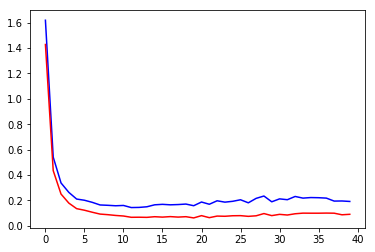

In [170]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses, color='b')
plt.plot(all_test_losses, color='r')

In [171]:
torch.save(rnn.state_dict(), './rnn_class.pth')

Evaluate results
-------------------

We now vizualize the performance of our model by creating a confusion matrix. The ground truth languages of samples are represented by rows in the matrix while the predicted languages are represented by columns.

In this evaluation we consider sequences of variable sizes rather than the fixed length sequences we used for training.

Test accuracy:  0.791


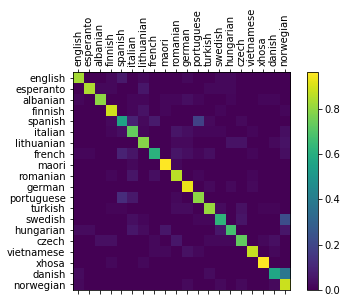

In [172]:
eval_batch_size = 1  # needs to be set to 1 for evaluating different sequence lengths

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_languages, n_languages)
n_confusion = 1000
num_correct = 0
total = 0

for i in range(n_confusion):
    eval_chunk_len = random.randint(10, 50) # in evaluation we will look at sequences of variable sizes
    input_data, target_category, text_data = load_random_batch(test_category_data, chunk_len=eval_chunk_len, batch_size=eval_batch_size)
    output = evaluate(rnn, input_data, seq_len=eval_chunk_len, batch_size=eval_batch_size)
    
    guess_i = categoryFromOutput(output)
    category_i = [int(target_category[idx]) for idx in range(len(target_category))]
    for j in range(eval_batch_size):
        category = all_categories[category_i[j]] 
        confusion[category_i[j]][guess_i[j]] += 1
        num_correct += int(guess_i[j]==category_i[j])
        total += 1

print('Test accuracy: ', float(num_correct)/float(n_confusion*eval_batch_size))

# Normalize by dividing every row by its sum
for i in range(n_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly.




Run on User Input
---------------------

Now you can test your model on your own input. 


In [135]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        input_data = stringToTensor(input_line).long().unsqueeze(0).to(device)
        output = evaluate(rnn, input_data, seq_len=len(input_line), batch_size=1)

    # Get top N categories
    topv, topi = output.topk(n_predictions, dim=1)
    predictions = []

    for i in range(n_predictions):
        topv.shape
        topi.shape
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('This is a phrase to test the model on user input')



> This is a phrase to test the model on user input
(13.70) english
(10.63) albanian
(2.25) swedish
(2.15) norwegian
(1.61) danish


# Output Kaggle submission file

Once you have found a good set of hyperparameters submit the output of your model on the Kaggle test file.

In [137]:
### DO NOT CHANGE KAGGLE SUBMISSION CODE ####
import csv

kaggle_test_file_path = 'language_data/kaggle_rnn_language_classification_test.txt'
with open(kaggle_test_file_path, 'r') as f:
    lines = f.readlines()

output_rows = []
for i, line in enumerate(lines):
    sample = line.rstrip()
    sample_chunk_len = len(sample)
    input_data = stringToTensor(sample).unsqueeze(0)
    output = evaluate(rnn, input_data, seq_len=sample_chunk_len, batch_size=1)
    guess_i = categoryFromOutput(output)
    output_rows.append((str(i+1), all_categories[guess_i]))

submission_file_path = 'kaggle_rnn_submission.txt'
with open(submission_file_path, 'w') as f:
    output_rows = [('id', 'category')] + output_rows
    writer = csv.writer(f)
    writer.writerows(output_rows)
